# Cookie cutter

The aim of this notebook is to produce summary statistics for Hazards over NCRA regions, with the flexibility to apply the method to any shapefile region.

Typical statistics include median, mean, min, max, 10th, 90th percentiles

This method has used guidance from [https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb]

<div>
<img src="cookie_cutter.jpg" width="500" title="Cookie cutter"/>
</div>

## Step 1 - access needed packages

In [1]:
# navigate to correct working directory

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages

In [4]:
import calendar

import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np
import pandas as pd

from glob import glob 
from datetime import datetime

In [5]:
# import os
# from dask.distributed import Client
# ncpus = os.environ.get('PBS_NCPUS')
# client = Client(n_workers=int(ncpus))
# client

In [6]:
# read in the shapefile with regions you will use
# from acs_plotting_maps import regions_dict
ncra_gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ncra_regions/ncra_regions.shp')
ncra_gdf["abbrevs"]=['VIC', 'NT','TAS', 'SA', 'NSW', 'WAN', 'WAS', 'SQ', 'NQ']
regions = regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs")
regions

<regionmask.Regions 'unnamed'>
overlap:  None

Regions:
0 VIC                Victoria
1  NT      Northern Territory
2 TAS                Tasmania
3  SA         South Australia
4 NSW   New South Wales & ACT
5 WAN Western Australia North
6 WAS Western Australia South
7  SQ        Queensland South
8  NQ        Queensland North

[9 regions]

In [41]:
def acs_region_fractional_stats(ds,
                                var, 
                                frac, 
                                start = None, 
                                end = None, 
                                dims = ("time", "lat", "lon"), 
                                how = "mean",
                                quantile = None, 
                                select_abbr = None,
                                select_name = None):
    """
    This function takes an Xarray dataset (ds) with variable (var) and dimensions time, lat, and lon, 
    then selections the time range between two years (start and end), 
    applies a fractional mask (frac) to compute a regional statistic (how, eg "mean") over two or three dimensions.

    Parameters
    ----------
    ds: xr.Dataset or xr.DataArray
        expects an xr.Dataset with variable var and dimensions time, lat, and lon.
        
    var: str
        name of variable in ds, eg "pr" or "tas".
        
    frac: xarray.DataArray 'mask'
        fractional mask from regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs").mask_3D_frac_approx(ds).
        
    start: string or int
        start year to slice data array. eg start year of global warming level GWL. If either start or end is None, then time selection is not performed. 
        
    end: string or int
        end year to slice data array. eg end year of global warming level GWL. If either start or end is None, then time selection is not performed. 
        
    dims: tuple of dimensions
        Dimensions to reduce data. Suggestion to reduce to one value per region: dims= ("time", "lat", "lon"). Or to reduce to 1D time series per region ("lat", "lon").
        
    how: str
        statistic to reduce data. One of ['mean', 'median', 'min', 'max', 'sum', 'std', 'var']. Default "mean".
    
    quantile: float [0.0,1.], optional
        Percentile to calculate. Will overwrite any "how" method

    select_abbr: list of str
        list of regions by abbreviation to perform statistic on. eg ["VIC", "NSW"]

    select_name: list of str
        list of regions by name to perform statistic on.  eg ["Victoria", "New South Wales & ACT"]
    
    Returns
    -------
    An xarray.DataArray (1D or 2D) with a dimension called "region" and values of the regional statistics.
    If no valid statistic is called through how or quantile, then the DataArrayWeighted is returned
    """
    if select_abbr is not None:
        frac = frac[np.isin(frac.abbrevs,list(select_abbr))]
    elif select_name is not None:
        frac = frac[np.isin(frac.names,list(select_name))]
    else:
        # use all regions
        frac = frac
    
    if start is not None and end is not None:
        # select GWL time slice
        ds = ds.sel(time = slice(str(start), str(end)))
    
    # calculate weights due to latitude
    lat_weights = np.cos(np.deg2rad(ds['lat']))
    # create your weighted 3D xr.Dataset
    ds_weighted = ds[var].weighted(frac * lat_weights)

    # perform a statistic calculation
    if quantile is not None:
        return ds_weighted.quantile(quantile, dim=dims)
    if how == "mean":
        return ds_weighted.mean(dim=dims)
    if how == "sum":
        return ds_weighted.sum(dim=dims)
    if how == "std":
        return ds_weighted.std(dim=dims)
    if how == "var":
        return ds_weighted.var(dim=dims)
    if how == "min":
        return ds_weighted.quantile(0.0, dim=dims)
    if how == "median":
        return ds_weighted.quantile(0.5, dim=dims)
    if how == "max":
        return ds_weighted.quantile(1., dim=dims)
        
    print("No statistic calculated. Please provide valid how, one of: ['mean', 'median', 'min', 'max', 'sum', 'std', 'var']")
    return ds_weighted


In [34]:
%%time 
# open Hazard data
# this is also a slow part of the code. It is likely to be reused if you're interested in calculating multiple statistics
ds = xr.open_dataset(filename, use_cftime = True,)

# calculate weighted mask this is a very slow part of the code and can be reused for any datasets using the same regions and the same lat lon
frac = regions.mask_3D_frac_approx(ds)


CPU times: user 19.8 s, sys: 46.5 s, total: 1min 6s
Wall time: 1min 6s


In [12]:
var = "pr"
start, end = ("1991", "2010") 
dims = ("time", "lat", "lon")
how = "mean"

## Step 2 - Load and prepare data

Open the data you need. 

Select the time slice. 

Depending on your data, maybe run calculations on original data eg calculate the annual mean.

In [8]:
# open Hazard data
# example data /g/data/ia39/ncra/extratropical_storms
ds = xr.open_dataset("/g/data/ia39/ncra/extratropical_storms/RX1D_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual.nc",
                     use_cftime = True,
                     )
ds

<xarray.Dataset> Size: 269MB
Dimensions:    (time: 55, bnds: 2, lon: 886, lat: 691)
Coordinates:
  * time       (time) object 440B 1960-07-02 00:00:00 ... 2014-07-02 12:00:00
  * lon        (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * lat        (lat) float64 6kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 880B ...
    lon_bnds   (lon, bnds) float64 14kB ...
    lat_bnds   (lat, bnds) float64 11kB ...
    pr         (time, lat, lon) float64 269MB ...
Attributes: (12/48)
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    source:                    historical run using CSIRO-ARCCSS ACCESS-CM2 r...
    institution:               Bureau of Meteorology
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    title:                     Pre-processed model output in preparation for ...
    ...                        ...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; historical; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    input_tracking_id:         043b77c3-c8db-4394-9486-49d0ae0a3e9c
    history:                   Thu Jun 06 12:17:46 2024: cdo mergetime /scrat...
    NCO:                       netCDF Operators version 5.0.5 (Homepage = htt...
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [9]:
#start and end date for GWL 
start = "1991"
end = "2010"

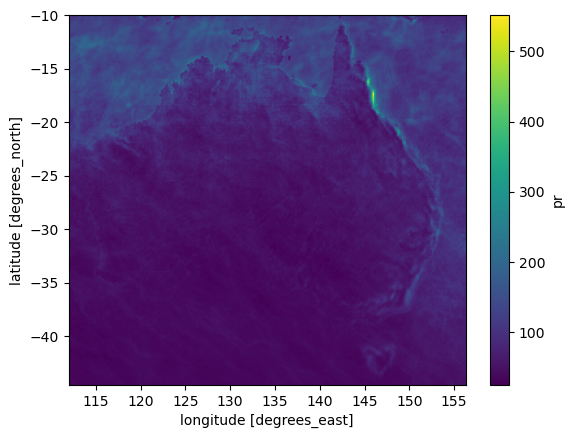

In [10]:
# calculate the mean rx1day value from the 20 years for the global warming level (GWL)
ds = ds.sel(time = slice(start, end))
da_mean = ds["pr"].mean(dim="time")
da_mean.plot()

## Create your mask

There's a range of ways to calculate your mask:
- **regions.mask_3D(ds)** will create a "mask" array that is ```True``` for all grid cells whose centre point falls within a particular state/territory and ```False``` elsewhere
- **regions.mask_3D_frac_approx(ds)** will calculate the fraction of each grid cell that overlaps with each shape
- **mask_10pct** you may create a mask from the fraction values we need to decide on a minimum overlap threshold. eg ```mask_10pct = frac >= 0.1```

We will use fractional masking ```regions.mask_3D_frac_approx(ds)``` which will weigh each lat lon grid by the approximate fraction of the area that lay within the shapefile geometery.

The masking methods return an xr.DataArray with three dimensions:  **region**, **lat**, and **lon**.

In [11]:
# fractional mask assigns values between [0,1] for each lat and lon
frac = regions.mask_3D_frac_approx(ds)
# frac

In [12]:
# Account for the area difference depending on latitude
lat_weights = np.cos(np.deg2rad(ds['lat']))


## Step: apply fractional mask to data

In [40]:
# create your weighted 3D xr.Dataset
ds_weighted = ds["pr"].weighted(frac * lat_weights)
ds_weighted

DataArrayWeighted with weights along dimensions: region, lat, lon

In [14]:
# or create your weigthed 2D xr.DataArray
da_weighted = da_mean.weighted(frac * lat_weights)


## Step : calculate a statistic to summarise each region

In [15]:
# for each timestep, calculate the mean
ds_weighted.mean(dim=("lat", "lon"))

<xarray.DataArray 'pr' (time: 20, region: 9)> Size: 1kB
array([[ 39.42378401,  78.6111467 ,  64.12961646,  27.60713668,
         52.35082646,  54.24510434,  36.55821389,  57.99790674,
        131.01746283],
       [ 34.87848857,  51.18625129,  52.76729739,  31.03302788,
         39.75247016,  52.12001675,  28.3066375 ,  45.45852858,
        118.10438182],
       [ 52.52318054,  83.19798577,  56.81671384,  35.46108726,
         61.83736986,  67.64327945,  40.74079656,  87.04141058,
         79.5396537 ],
       [ 50.73915531,  92.28623842,  48.91293077,  49.42442501,
         67.07733983,  86.30276879,  54.97314157,  67.7483537 ,
        109.96485017],
       [ 48.44917963, 101.06577245,  51.57168754,  35.78564451,
         56.87829875,  90.42917044,  55.32130505,  66.66520947,
        128.77136065],
       [ 35.88845261, 107.17087658,  67.10929841,  35.59989586,
         38.05280578, 108.62650393,  63.87321835,  53.32872903,
         69.83421602],
       [ 43.06933635,  89.92818711,  64.84850761,  48.96098972,
         55.92106079,  67.3212945 ,  51.06044891,  74.28985165,
...
         48.40809541,  77.47620159,  50.68366236,  46.19192621,
         90.40371836],
       [ 44.8050854 ,  76.23687902,  51.02861047,  34.29573248,
         52.4252649 ,  71.90962605,  36.70436141,  53.98221965,
         88.25193234],
       [ 49.32038712,  56.37771275,  49.13745798,  34.83940861,
         63.26666689,  71.92709601,  51.23321799,  56.82923432,
         60.22444668],
       [ 54.35034856, 146.70561298,  59.50152395,  61.50704364,
         63.29890361,  73.35852124,  52.76628118,  78.30036151,
         79.45272298],
       [ 48.55614509,  87.51113205,  49.79647568,  44.49264222,
         60.71486084,  93.8785893 ,  47.50935512,  58.24764564,
         89.75751375],
       [ 52.56734336,  57.38911548,  66.94701825,  41.03680095,
         45.96425402,  63.65263174,  42.27499525,  50.86752198,
         58.53360625],
       [ 42.07556069,  69.90889356,  46.68747423,  58.06398629,
         60.58862247, 116.00728809,  77.34977713,  76.55120588,
         83.24977585]])
Coordinates:
  * time     (time) object 160B 1991-07-02 12:00:00 ... 2010-07-02 12:00:00
  * region   (region) int64 72B 0 1 2 3 4 5 6 7 8
    abbrevs  (region) <U2 72B 'r0' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8'
    names    (region) <U23 828B 'Victoria' ... 'Queensland North'

In [16]:
# for all time, calculate one mean value for each region
ds_weighted.mean(dim=("time", "lat", "lon"))

<xarray.DataArray 'pr' (region: 9)> Size: 72B
array([48.29607028, 85.38559917, 56.84069119, 41.98991372, 57.87682356,
       78.22834357, 48.4225218 , 64.71085976, 90.65452625])
Coordinates:
  * region   (region) int64 72B 0 1 2 3 4 5 6 7 8
    abbrevs  (region) <U2 72B 'r0' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8'
    names    (region) <U23 828B 'Victoria' ... 'Queensland North'

In [17]:
# using the 2D array, calculate one mean value for each region
da_weighted.mean(dim=("lat", "lon"))

<xarray.DataArray 'pr' (region: 9)> Size: 72B
array([48.29607028, 85.38559917, 56.84069119, 41.98991372, 57.87682356,
       78.22834357, 48.4225218 , 64.71085976, 90.65452625])
Coordinates:
  * region   (region) int64 72B 0 1 2 3 4 5 6 7 8
    abbrevs  (region) <U2 72B 'r0' 'r1' 'r2' 'r3' 'r4' 'r5' 'r6' 'r7' 'r8'
    names    (region) <U23 828B 'Victoria' ... 'Queensland North'

In [9]:
#start and end date for GWL 
start = "1991"
end = "2010"

In [21]:
%history

# navigate to correct working directory
cd /g/data/mn51/users/gt3409/plotting_maps/
# import needed packages
import calendar

import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np
import pandas as pd

from glob import glob 
from datetime import datetime
%%time
# preload this and make regions and global variable
# more Australian regions are available here /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/
ncra_gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ncra_regions/ncra_regions.shp')
ncra_gdf["abbrevs"]=['VIC', 'NT','TAS', 'SA', 'NSW', 'WAN', 'WAS', 'SQ', 'NQ']
regions = regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs")
def acs_regional_stats(ds,
                        var, 
                        mask = None, 
                        start = None, 
                        end = None, 
                        dims = ("time", "lat", "lon"),

In [ ]:
# navigate to correct working directory
cd /g/data/mn51/users/gt3409/plotting_maps/
# import needed packages
import calendar

import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np
import pandas as pd

from glob import glob 
from datetime import datetime
%%time
# preload this and make regions and global variable
# more Australian regions are available here /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/
ncra_gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ncra_regions/ncra_regions.shp')
ncra_gdf["abbrevs"]=['VIC', 'NT','TAS', 'SA', 'NSW', 'WAN', 'WAS', 'SQ', 'NQ']
regions = regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs")
def acs_regional_stats(ds,
                        var, 
                        mask = None, 
                        start = None, 
                        end = None, 
                        dims = ("time", "lat", "lon"), 
                        how = "mean",
                        quantile = None, 
                        select_abbr = None,
                        select_name = None,
                        overlap_threshold = None):
    """
    This function takes an Xarray dataset (ds) with variable (var) and dimensions time, lat, and lon, 
    then selections the time range between two years (start and end), 
    applies regions.mask_3D_frac_approx fractional mask (frac) to compute a regional statistic (how, eg "mean") over two or three dimensions.

    Parameters
    ----------
    ds: xr.Dataset or xr.DataArray
        expects an xr.Dataset with variable var and dimensions time, lat, and lon.
        
    var: str
        name of variable in ds, eg "pr" or "tas".

    mask:  xarray.DataArray 'mask' or ["fractional", "centred", "min_overlap"] 
        expects a precalculated mask, or will calculate one of the three options. If "min_overlap" selected, you must provide an overlap_threshold value.
        fractional mask from regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs").mask_3D_frac_approx(ds). 
        If None is provided, then will calculate a fractional mask based on NCRA regions, but this will take about one minute to calculate. 
        This is best avoided by calculating frac outside the function.
        
    start: string or int
        start year to slice data array. eg start year of global warming level GWL. If either start or end is None, then time selection is not performed. 
        
    end: string or int
        end year to slice data array. eg end year of global warming level GWL. If either start or end is None, then time selection is not performed. 
        
    dims: tuple of dimensions
        Dimensions to reduce data. Suggestion to reduce to one value per region: dims= ("time", "lat", "lon"). Or to reduce to 1D time series per region ("lat", "lon").
        
    how: str
        statistic to reduce data. One of ['mean', 'median', 'min', 'max', 'sum', 'std', 'var']. Default "mean".
    
    quantile: float [0.0,1.], optional
        Percentile to calculate. Will overwrite any "how" method

    select_abbr: list of str
        list of regions by abbreviation to perform statistic on. eg ["VIC", "NSW"]

    select_name: list of str
        list of regions by name to perform statistic on.  eg ["Victoria", "New South Wales & ACT"]

    overlap_threshold: float between 0.0 and 1.
        If mask =  "min_overlap", you must provide an overlap_threshold value.
        If mask != "min_overlap", this value will be ignored.
    
    Returns
    -------
    An xarray.DataArray (1D or 2D) with a dimension called "region" and values of the regional statistics.
    If no valid statistic is called through how or quantile, then the DataArrayWeighted is returned
    """
    if isinstance(mask, xr.DataArray):
        # Prefered method: use precalculated xarray.DataArray 'mask'
        mask = mask
    elif mask == "fractional":
        # !warning very slow!
        print("!warning very slow! Calculating fractional mask every time is very slow. \
        \nPlease calculate ```mask = regions.mask_3D_frac_approx(ds)``` before this function.")
        mask = regions.mask_3D_frac_approx(ds)
    elif mask == "centred":
        # !warning slow!
        print("!warning slow! Calculating mask every time is slow. \
        \nPlease calculate ```mask = regions.mask_3D(ds)``` before this function.")
        mask = regions.mask_3D(ds)
    elif mask == "min_overlap":
        # !warning very slow!
        print("!warning very slow! Calculating fractional mask with minimum overlap every time is very slow. \
        \nPlease calculate ```mask = regions.mask_3D_frac_approx(ds) >= overlap_threshold``` before this function.")
        assert (0. <= overlap_threshold <= 1.), "You have selected min_overlap mask. Please specify overlap_threshold between [0.,1.]"
        mask = regions.mask_3D_frac_approx(ds) >= overlap_threshold
    else:
        print("ERROR: missing mask. mask must be xarray.DataArray 'mask' or ['fractional', 'centred', 'min_overlap']. Aborting ...")
        return
        
    if select_abbr is not None:
        mask = mask[np.isin(mask.abbrevs,list(select_abbr))]
    elif select_name is not None:
        mask = mask[np.isin(mask.names,list(select_name))]
    else:
        # use all regions
        mask = mask
    
    if start is not None and end is not None:
        # select GWL time slice
        ds = ds.sel(time = slice(str(start), str(end)))
    
    # calculate weights due to latitude
    lat_weights = np.cos(np.deg2rad(ds['lat']))
    # create your weighted 3D xr.Dataset
    ds_weighted = ds[var].weighted(mask * lat_weights)

    # perform a statistic calculation
    if quantile is not None:
        return ds_weighted.quantile(quantile, dim=dims)
    if how == "mean":
        return ds_weighted.mean(dim=dims)
    if how == "sum":
        return ds_weighted.sum(dim=dims)
    if how == "std":
        return ds_weighted.std(dim=dims)
    if how == "var":
        return ds_weighted.var(dim=dims)
    if how == "min":
        return ds_weighted.quantile(0.0, dim=dims)
    if how == "median":
        return ds_weighted.quantile(0.5, dim=dims)
    if how == "max":
        return ds_weighted.quantile(1., dim=dims)
        
    print("No statistic calculated. Please provide valid how, one of: ['mean', 'median', 'min', 'max', 'sum', 'std', 'var']")
    return ds_weighted
# read in the shapefile with regions you will use
# from acs_plotting_maps import regions_dict
ncra_gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ncra_regions/ncra_regions.shp')
ncra_gdf["abbrevs"]=['VIC', 'NT','TAS', 'SA', 'NSW', 'WAN', 'WAS', 'SQ', 'NQ']
regions = regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs")
regions
%%time 
# open Hazard data
# this is a slowish part of the code. It is likely to be reused if you're interested in calculating multiple statistics
filename = "/g/data/ia39/ncra/extratropical_storms/5km/RX1D_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
%%time
# calculate weighted mask this is a very slow part of the code and can be reused for any datasets using the same regions and the same lat lon
mask_frac = regions.mask_3D_frac_approx(ds)
%%time
mask_centred = regions.mask_3D(ds)
# calculate the stats using the acs_region_fractional_stats function
var = "pr"
start, end = ("1991", "2010") 
dims = ("time", "lat", "lon")
how = "mean"
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "fractional", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "centred", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "min_overlap", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean", overlap_threshold=0.3)
da_mean.to_dataframe()

%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean")
da_mean.to_dataframe()
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean")
da_mean.to_dataframe(dim_order=["region", "time"])
%%time
# calculate the mean rx1day value from the 20 years for the global warming level (GWL)
ds = ds.sel(time = slice(start, end))
da_mean = ds["pr"].mean(dim="time")
da_mean.plot()
%history
